In [3]:
from gerrychain import Graph

In [4]:
# Read Oklahoma county graph from the json file "OK_county.json"
filepath = 'C:\\districting-data\\'
filename = 'OK_county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

In [5]:
# For each node, print the node #, county name, and its population
for node in G.nodes:
    name = G.nodes[node]["NAME10"]
    population = G.nodes[node]['TOTPOP']
    print("Node",node,"represents",name,"County and its population in year 2010 was",population)

Node 0 represents Payne County and its population in year 2010 was 77350
Node 1 represents Caddo County and its population in year 2010 was 29600
Node 2 represents Delaware County and its population in year 2010 was 41487
Node 3 represents Marshall County and its population in year 2010 was 15840
Node 4 represents Greer County and its population in year 2010 was 6239
Node 5 represents Coal County and its population in year 2010 was 5925
Node 6 represents Seminole County and its population in year 2010 was 25482
Node 7 represents Murray County and its population in year 2010 was 13488
Node 8 represents Jefferson County and its population in year 2010 was 6472
Node 9 represents Tillman County and its population in year 2010 was 7992
Node 10 represents McIntosh County and its population in year 2010 was 20252
Node 11 represents Choctaw County and its population in year 2010 was 15205
Node 12 represents Harper County and its population in year 2010 was 3685
Node 13 represents Grant County 

In [6]:
# We will instead use 2019 population numbers (according to DRA).

population_2019 = {
        'Adair' : 22220,
        'Alfalfa' : 5847,
        'Atoka' : 13823,
        'Beaver' : 5377,
        'Beckham' : 22268,
        'Blaine' : 9556,
        'Bryan' : 46457,
        'Caddo' : 29242,
        'Canadian' : 140455,
        'Carter' : 48319,
        'Cherokee' : 48664,
        'Choctaw' : 14807,
        'Cimarron' : 2174,
        'Cleveland' : 279274,
        'Coal' : 5581,
        'Comanche' : 121762,
        'Cotton' : 5858,
        'Craig' : 14390,
        'Creek' : 71427,
        'Custer' : 29152,
        'Delaware' : 42433,
        'Dewey' : 4922,
        'Ellis' : 4015,
        'Garfield' : 61898,
        'Garvin' : 27835,
        'Grady' : 55071,
        'Grant' : 4397,
        'Greer' : 5861,
        'Harmon' : 2710,
        'Harper' : 3760,
        'Haskell' : 12687,
        'Hughes' : 13372,
        'Jackson' : 25063,
        'Jefferson' : 6158,
        'Johnston' : 11064,
        'Kay' : 44402,
        'Kingfisher' : 15694,
        'Kiowa' : 8886,
        'Latimer' : 10348,
        'Le Flore' : 50026,
        'Lincoln' : 34895,
        'Logan' : 46683,
        'Love' : 10063,
        'McClain' : 39247,
        'McCurtain' : 33016,
        'McIntosh' : 19725,
        'Major' : 7692,
        'Marshall' : 16505,
        'Mayes' : 41044,
        'Murray' : 13946,
        'Muskogee' : 68736,
        'Noble' : 11335,
        'Nowata' : 10322,
        'Okfuskee' : 12067,
        'Oklahoma' : 787216,
        'Okmulgee' : 38749,
        'Osage' : 47226,
        'Ottawa' : 31454,
        'Pawnee' : 16412,
        'Payne' : 81815,
        'Pittsburg' : 44146,
        'Pontotoc' : 38355,
        'Pottawatomie' : 72154,
        'Pushmataha' : 11128,
        'Roger Mills' : 3667,
        'Rogers' : 91353,
        'Seminole' : 24832,
        'Sequoyah' : 41709,
        'Stephens' : 43647,
        'Texas' : 20805,
        'Tillman' : 7413,
        'Tulsa' : 646419,
        'Wagoner' : 78958,
        'Washington' : 51886,
        'Washita' : 11225,
        'Woods' : 9043,
        'Woodward' : 20727                   
}

In [11]:
for node in G.nodes:
    name = G.nodes[node]["NAME10"]
    G.nodes[node]['POP19'] = population_2019[name]
    
print("population of Payne County is",G.nodes[0]['POP19'])

population of Payne County is 81815


In [12]:
# what is the total 2019 population?
total_population_2019 = sum( G.nodes[i]['POP19'] for i in G.nodes )

# Let's set lower and upper population bounds on the districts
k = 48              # number of districts
deviation = 0.05     # 5% deviation (+/-2.5%)

import math
L = math.ceil( (1 - deviation / 2) * total_population_2019 / k )
U = math.floor( (1 + deviation / 2) * total_population_2019 / k )

print("Total population =",total_population_2019)
print("Desired number of districts =",k)
print("Ideal population =",total_population_2019 / k)
print("Lower population threshold =",L)
print("Upper population threshold =",U)

Total population = 3932870
Desired number of districts = 48
Ideal population = 81934.79166666667
Lower population threshold = 79887
Upper population threshold = 83983


In [13]:
# Let's find a large subset of counties B with the property 
#    that every component of G[B] has population less than L.
#
# This is used to help speed up the computations, but has no 
#    bearing on the final results themselves.

import networkx as nx
DG = nx.DiGraph(G) # bidirected version of G

import gurobipy as gp
from gurobipy import GRB

bm = gp.Model()

# X[i,j]=1 if vertex i is assigned to bin j
bX = bm.addVars(DG.nodes, k, vtype=GRB.BINARY) 

# B[i]=1 if vertex i is selected
bB = bm.addVars(DG.nodes, vtype=GRB.BINARY)

# set objective, maximize number of vertices in B
bm.setObjective( gp.quicksum( bB[i] for i in DG.nodes ), GRB.MAXIMIZE )

# relate X and B vars
bm.addConstrs( bB[i] == gp.quicksum( bX[i,j] for j in range(k) ) for i in DG.nodes)

# bin capacity constraints
bm.addConstrs( gp.quicksum( G.nodes[i]['POP19'] * bX[i,j] for i in G.nodes ) <= L-1 for j in range(k) )

# bin conflict constraints
bm.addConstrs( bX[u,j] + bB[v] <= 1 + bX[v,j] for u,v in DG.edges for j in range(k) )

# solve and return B
bm.Params.TimeLimit = 60
bm.optimize()

B = [i for i in DG.nodes if bB[i].x > 0.5]
B_names = [ G.nodes[i]['NAME10'] for i in B ]

print("B =",B)
print("B county names =",B_names)

Academic license - for non-commercial use only - expires 2021-04-22
Using license file C:\Users\buchanan\gurobi.lic
Changed value of parameter TimeLimit to 60.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 18845 rows, 3773 columns and 63629 nonzeros
Model fingerprint: 0x2ab8e60d
Variable types: 0 continuous, 3773 integer (3773 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 3463 rows and 343 columns
Presolve time: 0.10s
Presolved: 15382 rows, 3430 columns, 52582 nonzeros
Variable types: 0 continuous, 3430 integer (3430 binary)

Root relaxation: objective 7.000000e+01, 5971 iterations, 0.94 seconds

    Nodes    |    Current Node    |     Objective Bound

In [14]:
# function used in sorting step in an upcoming cell
def sort_by_second(val):
    return val[1]   

In [15]:
# Solve county clustering problem:
#
# Group the counties into contiguous clusters so that each has
#   population that is an integer multiple of the ideal population     
#

m = gp.Model()

# X[i,j]=1 if vertex i is assigned to (cluster centered at) vertex j
X = m.addVars(DG.nodes, DG.nodes, vtype=GRB.BINARY) 

# Y[j] = # of clusters centered at vertex j
Y = m.addVars(DG.nodes, vtype=GRB.INTEGER)

# Set objective function, maximize number of clusters
m.setObjective( gp.quicksum( X[j,j] for j in DG.nodes ), GRB.MAXIMIZE ) 

In [16]:
# Add base constraints

# Each county i assigned to one cluster
m.addConstrs( gp.quicksum( X[i,j] for j in DG.nodes ) == 1 for i in DG.nodes )

# Cluster "sizes" should sum to k
m.addConstr( gp.quicksum(Y[j] for j in DG.nodes) == k )

# Population balance: population of cluster j should be in [L,U] * Y[j]
m.addConstrs( gp.quicksum( G.nodes[i]['POP19'] * X[i,j] for i in DG.nodes ) <= U * Y[j] for j in DG.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['POP19'] * X[i,j] for i in DG.nodes ) >= L * Y[j] for j in DG.nodes )

# Enforce relationships between X[i,j] and X[j,j] and Y[j]
m.addConstrs( X[j,j] <= Y[j] for j in DG.nodes )
m.addConstrs( Y[j] <= DG.number_of_nodes() * X[j,j] for j in DG.nodes )
m.addConstrs(X[i,j] <= X[j,j] for i in DG.nodes for j in DG.nodes)

m.update()

In [17]:
# Add contiguity constraints

# F[j,u,v] tells how much flow (from source j) is sent across arc (u,v)
F = m.addVars(DG.nodes, DG.edges, vtype=GRB.CONTINUOUS)
M = DG.number_of_nodes() - 1
for j in DG.nodes:
    m.addConstr( sum(F[j,u,j] for u in DG.neighbors(j) ) == 0 )
    for i in DG.nodes:
        if i!=j:
            m.addConstr( sum(F[j,u,i] for u in DG.neighbors(i) ) - sum(F[j,i,u] for u in DG.neighbors(i)) == X[i,j] )
            m.addConstr( sum(F[j,u,i] for u in DG.neighbors(i) ) <= M * X[i,j] )

In [18]:
# This cell: computational speedups 

# Set branch priority on center vars
for j in DG.nodes:
    X[j,j].BranchPriority = 1
    Y[j].BranchPriority = 1
        
# Variable fixing based on set B
V_B_with_population = [(i,G.nodes[i]['POP19']) for i in G.nodes if i not in B]
V_B_with_population.sort(key=sort_by_second,reverse=True)
ordering = [v for (v,p) in V_B_with_population] + B   

# diagonal fixing based on ordering
for p in range(len(ordering)):
    i = ordering[p]
    for q in range(p+1,len(ordering)):
        j = ordering[q]
        X[i,j].UB = 0

# L fixing
for i in DG.nodes:
    for j in B:
        X[i,j].UB = 0

In [19]:
# solve
m.Params.TimeLimit = 7200 # 2-hour time limit
m.optimize()

Changed value of parameter TimeLimit to 7200.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 18096 rows, 36036 columns and 131044 nonzeros
Model fingerprint: 0xb214258d
Variable types: 30030 continuous, 6006 integer (5929 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 11835 rows and 25763 columns
Presolve time: 0.26s
Presolved: 6261 rows, 10273 columns, 39058 nonzeros
Variable types: 8080 continuous, 2193 integer (2149 binary)

Root relaxation: objective 2.926373e+01, 4066 iterations, 0.50 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   29.26373    0  195          -   29.263

   171   196   24.79151   21  372   18.00000   24.87097  38.2%  7091  393s
   195   220   24.77180   24  381   18.00000   24.87097  38.2%  6650  399s
   221   247   24.76410   27  380   18.00000   24.87097  38.2%  6193  404s
   258   265   24.50520   31  317   18.00000   24.87097  38.2%  5584  410s
   296   273   24.00000   35  219   18.00000   24.87097  38.2%  5091  415s
   318   274 infeasible   40        18.00000   24.86644  38.1%  4939  422s
   332   279   24.74141    5  565   18.00000   24.86644  38.1%  5047  433s
   343   286   24.72668    6  560   18.00000   24.86644  38.1%  5086  439s
   350   293   24.72642    8  549   18.00000   24.86644  38.1%  5185  445s
   359   303   24.71341   10  449   18.00000   24.86644  38.1%  5254  450s
   369   314   24.71341   12  426   18.00000   24.86644  38.1%  5320  458s
   380   325   24.69271   15  469   18.00000   24.86644  38.1%  5436  464s
   391   342   24.69266   17  434   18.00000   24.86644  38.1%  5516  469s
   410   388   24.56344  

  1196   906   21.00000   44  607   18.00000   23.60205  31.1%  3771 1074s
  1197   907   21.00000   32  623   18.00000   23.60067  31.1%  3768 1079s
  1198   908   23.59989    8  610   18.00000   23.59989  31.1%  3765 1081s
  1199   908   23.59855   34  604   18.00000   23.59855  31.1%  3761 1085s
  1201   910   19.00000   70  582   18.00000   23.59612  31.1%  3755 1094s
  1202   910   20.29395   39  572   18.00000   23.59510  31.1%  3752 1098s
  1203   911   23.59439    8  560   18.00000   23.59439  31.1%  3749 1107s
  1204   912   23.59405   13  585   18.00000   23.59405  31.1%  3746 1110s
  1206   913   21.00000   35  628   18.00000   23.59281  31.1%  3740 1115s
  1209   915   23.58996   15  630   18.00000   23.58996  31.1%  3730 1121s
  1210   916   23.58941    8  629   18.00000   23.58941  31.1%  3727 1126s
  1212   917   23.58710   16  644   18.00000   23.58710  31.0%  3721 1130s
  1214   918   19.00000   71  588   18.00000   23.58422  31.0%  3715 1137s
  1215   919   23.58236  

  1379   981   23.24163   16  524   21.00000   23.24163  10.7%  4708 1657s
  1380   982   23.24163   29  511   21.00000   23.24163  10.7%  4704 1660s
  1382   983   23.24163   28  599   21.00000   23.24163  10.7%  4698 1667s
  1383   984   23.24163   12  575   21.00000   23.24163  10.7%  4694 1670s
  1385   985   21.99762   44  609   21.00000   23.24163  10.7%  4687 1676s
  1387   987   23.24163   20  728   21.00000   23.24163  10.7%  4681 1682s
  1389   988   23.24163   26  600   21.00000   23.24163  10.7%  4674 1689s
  1390   989   23.24163   20  601   21.00000   23.24163  10.7%  4671 1696s
  1391   989   23.24163   20  588   21.00000   23.24163  10.7%  4667 1701s
  1393   991   23.24038   32  610   21.00000   23.24038  10.7%  4660 1706s
  1395   992   21.00000   36  621   21.00000   23.23848  10.7%  4654 1712s
  1396   993   21.00000   44  613   21.00000   23.23788  10.7%  4650 1715s
  1399   995   23.23525   34  612   21.00000   23.23525  10.6%  4641 1722s
  1400   995   23.23472  

  3689  1710   22.75334   71  366   21.00000   23.11693  10.1%  5118 3441s
  3744  1727   22.69472   50  519   21.00000   23.11040  10.0%  5162 3501s
  3814  1747   23.04286   44  532   21.00000   23.11040  10.0%  5221 3564s
  3897  1751   22.72078   48  507   21.00000   23.11040  10.0%  5227 3643s
  3965  1764   22.56603   53  475   21.00000   23.10286  10.0%  5249 3704s
  4028  1800   22.59929   46  579   21.00000   23.10155  10.0%  5300 3773s
  4131  1794   22.57176   51  482   21.00000   23.10155  10.0%  5330 3830s
  4190  1813   22.11382   63  407   21.00000   23.09955  10.0%  5388 3900s
  4270  1817   22.54720   57  386   21.00000   23.09443  10.0%  5438 3971s
  4354  1823   22.63811   49  522   21.00000   23.09199  10.0%  5463 4048s
  4419  1846   22.62052   51  488   21.00000   23.09174  10.0%  5510 4155s
  4536  1860   22.63659   53  506   21.00000   23.08319  9.92%  5523 4268s
  4640  1917   22.40188   54  499   21.00000   23.07110  9.86%  5564 4386s
  4749  2001     cutoff  

In [20]:
# What are the cluster "centers"?
centers = [j for j in DG.nodes if Y[j].x > 0.5]

print("********************************")
print("********************************")

# Print info about each cluster
clusters = list()
for j in centers:
    cluster_nodes = [ i for i in DG.nodes if X[i,j].x > 0.5 ]
    cluster_names = [ G.nodes[i]['NAME10'] for i in cluster_nodes ]
    cluster_population = sum( G.nodes[node]['POP19'] for node in cluster_nodes )
    cluster_size = int(Y[j].x)
    print("Cluster rooted at node",j,"(",G.nodes[j]['NAME10']," County ) has total population",cluster_population,"and should be split into",cluster_size,"district(s).")
    print("Cluster nodes are",cluster_nodes,"which correspond to counties:",cluster_names)
    print("Average district in this cluster should have population",cluster_population/cluster_size)
    print("********************************")
    print("********************************")
    clusters.append(cluster_nodes)
    
print("There are",len(clusters),"clusters:",clusters)

********************************
********************************
Cluster rooted at node 0 ( Payne  County ) has total population 81815 and should be split into 1 district(s).
Cluster nodes are [0] which correspond to counties: ['Payne']
Average district in this cluster should have population 81815.0
********************************
********************************
Cluster rooted at node 2 ( Delaware  County ) has total population 83477 and should be split into 1 district(s).
Cluster nodes are [2, 36] which correspond to counties: ['Delaware', 'Mayes']
Average district in this cluster should have population 83477.0
********************************
********************************
Cluster rooted at node 11 ( Choctaw  County ) has total population 82740 and should be split into 1 district(s).
Cluster nodes are [11, 34, 37, 55] which correspond to counties: ['Choctaw', 'Pushmataha', 'Bryan', 'Latimer']
Average district in this cluster should have population 82740.0
***********************

In [21]:
# Map the clusters
import geopandas as gpd

filepath = 'C:\\districting-data\\'
filename = 'OK_county.shp'
df = gpd.read_file( filepath + filename )

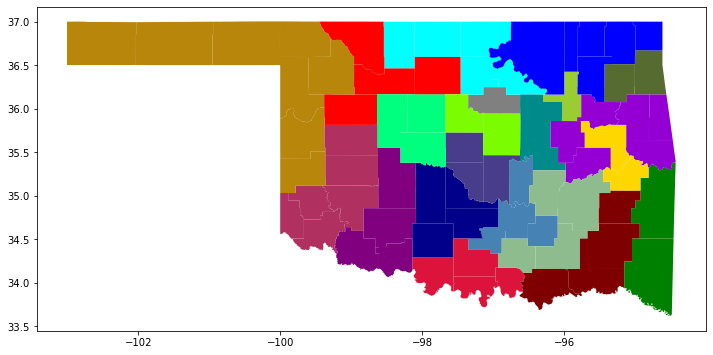

In [22]:
# Which cluster is each county assigned to?
assignment = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(len(clusters)):
    
    # for each node i in this cluster
    for i in clusters[j]:
        
        # What is its GEOID?
        geoID = G.nodes[i]["GEOID10"]
        
        # Need to find this GEOID in the dataframe
        for u in G.nodes:
            if geoID == df['GEOID10'][u]: # Found it
                assignment[u] = j # Node u from the dataframe should be assigned to district j

# Now add the assignments to a column of the dataframe and map it
pallette = ['#808080','#556b2f','#7f0000','#483d8b','#008000','#b8860b','#008b8b','#4682b4','#9acd32','#00008b','#8fbc8f','#800080','#b03060','#ff0000','#ffd700','#7cfc00','#9400d3','#00ff7f','#dc143c','#00ffff','#0000ff','#da70d6','#1e90ff','#fa8072','#90ee90','#add8e6','#ff1493','#7b68ee','#ffdead','#ffb6c1']
colors = [pallette[assignment[node]] for node in G.nodes]
df['colors'] = colors
my_fig = df.plot(color=df['colors']).get_figure()
RESIZE_FACTOR = 2
my_fig.set_size_inches(my_fig.get_size_inches()*RESIZE_FACTOR)

In [23]:
# The county clusters can be split in many, many ways. Here is one possible way
import webbrowser

webbrowser.open('https://davesredistricting.org/join/9ff06581-03d0-40b3-9fad-1650c9ed0b6c')  

True